In [2]:
import os
import scipy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import math
%matplotlib inline

from collections import defaultdict
from pathlib import Path



def get_training_data(path):    # path to read data from
    raw_panda_data = pd.read_csv(path)

    # append a column of ones to the front of the data set
    
    num_columns = raw_panda_data.shape[1]                       # (num_rows, num_columns)
    panda_X = raw_panda_data.iloc[:,0:num_columns-1]            # [ slice_of_rows, slice_of_columns ]
    panda_y = raw_panda_data.iloc[:,num_columns-1:num_columns]  # [ slice_of_rows, slice_of_columns ]

    X = np.matrix(panda_X.values)   # pandas.DataFrame -> numpy.ndarray -> numpy.matrix
    Y = np.array(panda_y.values)   # pandas.DataFrame -> numpy.ndarray -> numpy.matrix

    return X, Y

def f(x):
    return 0.5*np.linalg.norm(X.dot(x).T-Y)**2

def grad_f(x):
    return (Q.dot(x)-X.T.dot(Y).T).A1

from sklearn import linear_model
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model = linear_model.LinearRegression(fit_intercept = False)
    model.fit(X,Y)
    
    return model.coef_

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip

--2021-02-04 22:47:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2583605 (2.5M) [application/x-httpd-php]
Saving to: ‘BlogFeedback.zip’

BlogFeedback.zip    100%[===================>]   2.46M  4.81MB/s    in 0.5s    

2021-02-04 22:47:42 (4.81 MB/s) - ‘BlogFeedback.zip’ saved [2583605/2583605]



In [4]:
!unzip BlogFeedback.zip

Archive:  BlogFeedback.zip
  inflating: blogData_test-2012.02.01.00_00.csv  
  inflating: blogData_test-2012.02.02.00_00.csv  
  inflating: blogData_test-2012.02.03.00_00.csv  
  inflating: blogData_test-2012.02.04.00_00.csv  
  inflating: blogData_test-2012.02.05.00_00.csv  
  inflating: blogData_test-2012.02.06.00_00.csv  
  inflating: blogData_test-2012.02.07.00_00.csv  
  inflating: blogData_test-2012.02.08.00_00.csv  
  inflating: blogData_test-2012.02.09.00_00.csv  
  inflating: blogData_test-2012.02.10.00_00.csv  
  inflating: blogData_test-2012.02.11.00_00.csv  
  inflating: blogData_test-2012.02.12.00_00.csv  
  inflating: blogData_test-2012.02.13.00_00.csv  
  inflating: blogData_test-2012.02.14.00_00.csv  
  inflating: blogData_test-2012.02.15.00_00.csv  
  inflating: blogData_test-2012.02.16.00_00.csv  
  inflating: blogData_test-2012.02.17.00_00.csv  
  inflating: blogData_test-2012.02.18.00_00.csv  
  inflating: blogData_test-2012.02.19.00_00.csv  
  inflating: blogData_t

In [5]:
X,Y=get_training_data('blogData_train.csv')
Y=Y/np.max(X)
X=X/np.max(X)
Q=X.T.dot(X)

In [6]:
def AARBCD(n_blocks, n_iter):
    N=X.shape[1]
    L=np.zeros(n_blocks-1)
    block_size=int(N/n_blocks)
    for i in np.arange(n_blocks-1):
        Q=X[:,block_size*i:block_size*i+block_size].T.dot(X[:,block_size*i:block_size*i+block_size])
        #print(Q.shape)
        L[i]=scipy.linalg.eigh(Q, eigvals_only=True, eigvals=(Q.shape[0]-1,Q.shape[0]-1))[0]    
    
    Q=X.T.dot(X)
    print(L)
    sigma=np.sum(np.sqrt(L))**2
    distrib=np.zeros(n_blocks-1)
    distrib=np.sqrt(L)/np.sqrt(sigma)

    A = 0; # init array of A_k
    x=np.zeros(N)
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    a = 1; #set L_0

    k=0
    #start_time = time.perf_counter()
    err=np.zeros(n_iter+1)
    err[0]=0.5*np.linalg.norm(Y)**2
    for i in range(n_iter):
    #while True:
        a = (1+np.sqrt(1+4*A))/2; #current trial for a
        A=A+a
        tau = a / A; #trial of \tau_{k}

        block_choice=np.random.choice(n_blocks-1,p=distrib)
        x_hat = tau * z + (1 - tau) * y; #trial for x_k ??? ??? ? ???????
        left=block_size*block_choice
        #block minimization over block_choice
        X_last=X[:,block_size*(n_blocks-1):]
        Y_last=Y-X.dot(x_hat).T+X_last.dot(x_hat[block_size*(n_blocks-1):]).T
        x=np.copy(x_hat)
        
        x[block_size*(n_blocks-1):]=fit_linear_reg(X_last,Y_last)
        

        #block minimization over last block
        X_temp=X[:,left:left+block_size]
        Y_temp=Y-X.dot(x).T+X_temp.dot(x[left:left+block_size]).T
        y=np.copy(x)
        y[left:left+block_size]=fit_linear_reg(X_temp,Y_temp)
        
        z[left:left+block_size]=z[left:left+block_size]- a/(sigma*distrib[block_choice])*(X.T.dot(X.dot(x).T-Y))[left:left+block_size].reshape(block_size)
        err[i+1]=0.5*np.linalg.norm(X.dot(y).T-Y)**2
    return err

def AAM(n_blocks, n_iter):
    
    N=X.shape[1]
    block_size=int(N/n_blocks)
    Q=X.T.dot(X)
    L=scipy.linalg.eigh(Q, eigvals_only=True, eigvals=(Q.shape[0]-1,Q.shape[0]-1))[0]   
    xi = np.zeros(N)
    eta = xi.copy()
    zeta = xi.copy()
    eta_new = xi.copy()
    zeta_new = xi.copy()
    grad2 = alpha_new = alpha = 0
    err=np.zeros(n_iter)
    err=np.zeros(n_iter+1)
    err[0]=0.5*np.linalg.norm(Y)**2
    for k in range(n_iter):
        alpha = 1/2/L + np.sqrt(1/(4*L**2) + alpha*alpha)
        tau = 1/(alpha*L)
        xi = tau*zeta + (1-tau)*eta
        grad_f_xi=(Q.dot(xi)-X.T.dot(Y).T).A1
        #print(grad_f_xi.shape)
        grad_norm_blocks=np.zeros(n_blocks)
        for i in range(n_blocks):
            #print(grad_f_xi[:,i*block_size:(i+1)*block_size].shape)
            grad_norm_blocks[i]=np.sum(np.square(grad_f_xi[i*block_size:(i+1)*block_size]))
    
        #print(grad_norm_blocks)
        #norm2_grad_f_xi = gu+gv)
        block_choice=np.argmax(grad_norm_blocks)
        X_temp=X[:,block_choice*block_size:(block_choice+1)*block_size]
        Y_temp=Y-X.dot(xi).T+X_temp.dot(xi[block_choice*block_size:(block_choice+1)*block_size]).T
        eta=np.copy(xi)        
        eta[block_choice*block_size:(block_choice+1)*block_size]=fit_linear_reg(X_temp,Y_temp)                
        zeta -= (alpha * grad_f_xi)
        err[k+1]=0.5*np.linalg.norm(X.dot(eta).T-Y)**2
        #print(eta[block_choice*block_size:(block_choice+1)*block_size])
    return err


In [7]:
def GoldenSectionSearch(f, v_k, x_k, eps, *args):
    tau = (math.sqrt(5) + 1)/2
    a_k = 0
    b_k = 1
    Nmin = math.floor(math.log((b_k - a_k)/eps, tau)) + 1
    y_k = a_k + (b_k - a_k)/tau/tau
    z_k = a_k + (b_k - a_k)/tau
    Current = f(v_k + y_k*(x_k - v_k), *args)
    IsNextZ = 1
    beta = y_k
    k = 1
    while (k < Nmin):
        if (IsNextZ == 1):
            ComputeNew = f(v_k + z_k*(x_k - v_k), *args)
            if (Current <= ComputeNew):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                IsNextZ = 0
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                Current = ComputeNew
                beta = z_k
        elif (IsNextZ == 0):
            ComputeNew = f(v_k + y_k*(x_k - v_k), *args)
            if (ComputeNew <= Current):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                Current = ComputeNew
                beta = y_k
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                IsNextZ = 1
        k += 1 
    return beta

def AAMLS(n_blocks, NumIter, f, gradf, eps, BinSearchStart, BinSearchMaxSteps, *args):
    N=X.shape[1]
    block_size=int(N/n_blocks)
    x0=np.zeros(N)
    k = 0
    v_k = np.copy(x0)
    x_k = np.copy(x0)
    A_k = 0
    farr = np.zeros(NumIter+1)
    fgradarr = np.zeros(NumIter)
    farr[0] = f(x_k, *args)
    fgradarr[0] = np.linalg.norm(gradf(x_k, *args))
    f_xk = farr[0]
    while (k < NumIter):
        beta = GoldenSectionSearch(f, v_k, x_k, eps, *args)
        y_k = v_k + beta*(x_k - v_k)
        #if (f(y_k)>f_xk):
        #    y_k=np.copy(x_k)
        grad_fy = gradf(y_k, *args)
        grad_norm_blocks=np.zeros(n_blocks)
        for i in range(n_blocks):
            #print(grad_f_xi[:,i*block_size:(i+1)*block_size].shape)
            grad_norm_blocks[i]=np.sum(np.square(grad_fy[i*block_size:(i+1)*block_size]))
    
        #print(grad_norm_blocks)
        #norm2_grad_f_xi = gu+gv)
        block_choice=np.argmax(grad_norm_blocks)
        X_temp=X[:,block_choice*block_size:(block_choice+1)*block_size]
        Y_temp=Y-X.dot(y_k).T+X_temp.dot(y_k[block_choice*block_size:(block_choice+1)*block_size]).T
        
        x_k=np.copy(y_k)        
        x_k[block_choice*block_size:(block_choice+1)*block_size]=fit_linear_reg(X_temp,Y_temp)        
        f_xk = f(x_k, *args)
        const = max(2*(f(y_k, *args) - f_xk)/(np.linalg.norm(grad_fy)**2),0)
        a_k = (const + (const**2 + 4*const*A_k)**0.5)/2
        A_k += a_k
        v_k -= a_k * grad_fy
        #print(A_k)
        farr[k+1] = f_xk
        k += 1
        #fgradarr[k] = linalg.norm(gradf(x_k, *args))
    return farr

In [8]:
model = linear_model.LinearRegression(fit_intercept = False)
model.fit(X,Y)
Y_pred=model.predict(X)
true_min=0.5*np.linalg.norm(Y-Y_pred)**2

In [9]:
n_iter=100
n_blocks=7
eps = 1e-4
BinSearchStart = 0.0001
BinSearchMaxSteps = 50

In [10]:
AARBCD_iter=AARBCD(n_blocks,n_iter)

[1.83600433e+01 3.54464339e+02 1.16641176e-05 1.98247446e-05
 5.20467858e-06 2.00023966e-05]


In [11]:
AAM_iter=AAM(n_blocks, n_iter)

In [12]:
AAMLS_iter=AAMLS(n_blocks, n_iter, f, grad_f, eps, BinSearchStart, BinSearchMaxSteps)

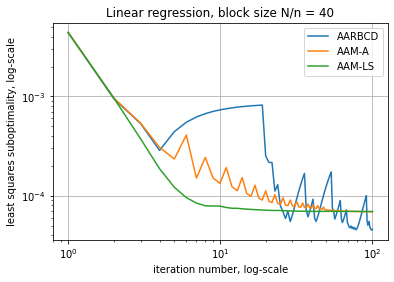

In [13]:
plt.plot(range(1,n_iter+2), AARBCD_iter-true_min, label='AAR-BCD')
plt.plot(range(1,n_iter+2), AAM_iter-true_min, label='AAM-A')
plt.plot(range(1,n_iter+2), AAMLS_iter-true_min, label='AAM-LS')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.title('Linear regression, block size N/n = '+str(int(X.shape[1]/n_blocks)))
plt.xlabel('iteration number, log-scale')
plt.ylabel('least squares suboptimality, log-scale')

plt.show()

In [64]:
n_iter=100
n_blocks=14
eps = 1e-7
BinSearchStart = 0.0001
BinSearchMaxSteps = 50

In [73]:
AARBCD_iter=AARBCD(n_blocks,n_iter)

[1.39264952e+01 4.54480157e+00 4.32926318e-01 3.54433934e+02
 1.48777583e-06 1.13000743e-05 5.87691922e-06 1.59673170e-05
 2.71747517e-06 3.98636998e-06 1.04564118e-05 1.14940842e-05
 1.18704472e-05]


In [16]:
AAM_iter=AAM(n_blocks, n_iter)

In [65]:
AAMLS_iter=AAMLS(n_blocks, n_iter, f, grad_f, eps, BinSearchStart, BinSearchMaxSteps)

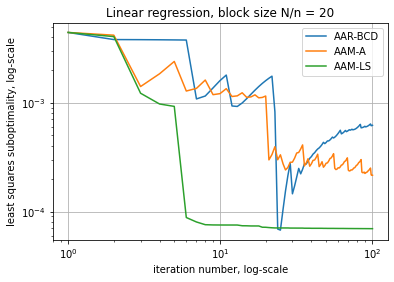

In [75]:
plt.plot(range(1,n_iter+2), AARBCD_iter-true_min, label='AAR-BCD')
plt.plot(range(1,n_iter+2), AAM_iter-true_min, label='AAM-A')
plt.plot(range(1,n_iter+2), AAMLS_iter-true_min, label='AAM-LS')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.title('Linear regression, block size N/n = '+str(int(X.shape[1]/n_blocks)))
plt.xlabel('iteration number, log-scale')
plt.ylabel('least squares suboptimality, log-scale')
plt.savefig('linear_reg_ratio_20', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
n_iter=100
n_blocks=28
eps = 1e-4
BinSearchStart = 0.0001
BinSearchMaxSteps = 50

In [ ]:
AARBCD_iter=AARBCD(n_blocks,n_iter)

[7.70451008e+00 6.26678894e+00 4.54416843e+00 1.48882581e-03
 2.34031669e-03 4.32426977e-01 3.54433933e+02 3.51819789e-06
 9.91926183e-07 1.40125338e-06 9.65487421e-06 3.48135369e-06
 3.70712116e-06 4.17890680e-06 1.03303166e-05 7.62956807e-06
 2.57474260e-06 1.47607517e-06 1.83836302e-06 3.41897210e-06
 5.07203573e-06 7.42657137e-06 6.57632732e-06 6.82708514e-06
 1.17940071e-05 6.65494352e-07 3.79297603e-06]


In [ ]:
AAM_iter=AAM(n_blocks, n_iter)

In [ ]:
AAMLS_iter=AAMLS(n_blocks, n_iter, f, grad_f, eps, BinSearchStart, BinSearchMaxSteps)

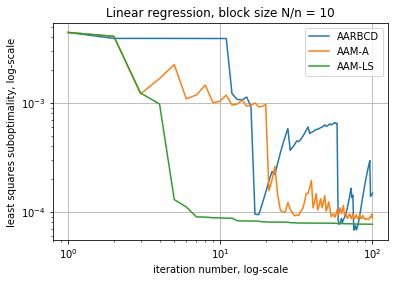

In [ ]:
plt.plot(range(1,n_iter+2), AARBCD_iter-true_min, label='AARBCD')
plt.plot(range(1,n_iter+2), AAM_iter-true_min, label='AAM-A')
plt.plot(range(1,n_iter+2), AAMLS_iter-true_min, label='AAM-LS')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.title('Linear regression, block size N/n = '+str(int(X.shape[1]/n_blocks)))
plt.xlabel('iteration number, log-scale')
plt.ylabel('least squares suboptimality, log-scale')
plt.show()

In [20]:
n_iter=100
n_blocks=56
eps = 1e-4
BinSearchStart = 0.0001
BinSearchMaxSteps = 50

In [51]:
AARBCD_iter=AARBCD(n_blocks,n_iter)

[5.08533215e+00 2.70728119e+00 2.67977595e+00 3.63589236e+00
 4.54356821e+00 1.28301303e-03 7.44806440e-04 7.44140499e-04
 1.08899616e-03 1.28151279e-03 4.32395905e-01 9.02721147e-05
 3.54433929e+02 8.01235080e-06 5.49180543e-07 3.49893943e-06
 5.23624096e-08 9.91834315e-07 7.46726262e-08 1.40110073e-06
 9.63245784e-06 3.95324812e-07 2.43985898e-06 2.59470800e-06
 3.70009598e-06 2.44183162e-07 6.44536615e-07 4.14150087e-06
 1.03293950e-05 7.96537295e-08 4.25581476e-06 5.54889070e-06
 4.69162574e-07 2.55276123e-06 2.68970062e-07 1.47483595e-06
 1.82191007e-06 3.93520877e-07 3.25055231e-06 1.21098892e-06
 2.65585513e-06 4.21231087e-06 7.30556065e-06 1.00243801e-06
 6.60818931e-07 6.53111663e-06 6.82610352e-06 8.76243135e-08
 4.34767964e-07 1.17593608e-05 4.09075670e-07 6.57809642e-07
 2.15907480e-06 3.35678075e-06 2.67833016e-06]


In [22]:
AAM_iter=AAM(n_blocks, n_iter)

In [23]:
AAMLS_iter=AAMLS(n_blocks, n_iter, f, grad_f, eps, BinSearchStart, BinSearchMaxSteps)

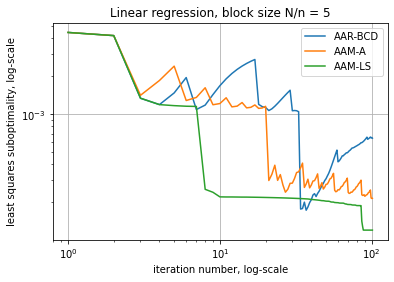

In [52]:
plt.plot(range(1,n_iter+2), AARBCD_iter-true_min, label='AAR-BCD')
plt.plot(range(1,n_iter+2), AAM_iter-true_min, label='AAM-A')
plt.plot(range(1,n_iter+2), AAMLS_iter-true_min, label='AAM-LS')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.title('Linear regression, block size N/n = '+str(int(X.shape[1]/n_blocks)))
plt.xlabel('iteration number, log-scale')
plt.ylabel('least squares suboptimality, log-scale')
plt.legend()
plt.savefig('linear_reg_ratio_5', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
AARBCD_iter[0]

0.011470784745389984

In [ ]:
AAM_iter[0]

0.011470784745389984

In [ ]:
AAMLS_iter[0]

0.011470784745389984

In [ ]:
AARBCD_iter[1]


0.008256822177785388

In [ ]:
AAM_iter[1]

0.011223685066174953

In [ ]:
AAMLS_iter[1]

0.011223685066174953